In [ ]:
%%capture
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Get MIND data

In [ ]:
behaviors = pd.read_csv("behaviors.tsv",
                        sep="\t",
                        header=None,
                        names=["impression_id", "user_id", "time", "history", "impressions"])
print("Behaviors shape:", behaviors.shape)

Behaviors shape: (376471, 5)


In [ ]:
news = pd.read_csv("news.tsv",
                   sep="\t",
                   header=None,
                   names=["news_id", "category", "sub_category", "title", "abstract", "url", "title_entities", "abstract_entites"])
print("News shape:", news.shape)

News shape: (72023, 8)


# Preprocessing

## The idea is to transform data to have only USER_ID, NEWS_ID, TOPIC_ID. The created dataframe will be used to build the graph connecting users based on the news they interacted with and connecting news based on their shared topics.


In [ ]:
list_users = []
list_news = []
list_topics = []
def nodes_gnewsrec(idx, user_id):
    if type(behaviors.loc[behaviors['user_id'] == user_id]['history'].values[0]) == str:
        hist = behaviors.loc[behaviors['user_id'] == user_id]['history'].values[0].split(' ')
        for item in hist:
            list_users.append(user_id)
            list_news.append(item)
            list_topics.append(news.loc[news['news_id'] == item]['category'].values[0])

In [ ]:
for idx, user_id in enumerate(tqdm(behaviors['user_id'][:3000])):
    nodes_gnewsrec(idx, user_id)

pre_data = {'user_id': list_users,
            'news_id': list_news,
            'topic_id': list_topics}

pre_df = pd.DataFrame(pre_data, columns= ['user_id', 'news_id', 'topic_id'])

  0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
topic_values = sorted(pre_df["topic_id"].unique())
topic_idx = {name: id for id, name in enumerate(topic_values)}

In [ ]:
list_users = []
list_news = []
list_topics = []

for i, user in enumerate(pre_df['user_id']):
    list_users.append(int(pre_df['user_id'].values[i][1:]))
    list_news.append(int(pre_df['news_id'].values[i][1:]))

list_topics = pre_df["topic_id"].apply(lambda value: topic_idx[value]).values.tolist()

dict_data = {'user_id': list_users,
             'news_id': list_news,
             'topic_id': list_topics}

df = pd.DataFrame(dict_data, columns= ['user_id', 'news_id', 'topic_id'])

In [ ]:
df.head()

,user_id,news_id,topic_id
0,134050,12246,3
1,134050,128820,4
2,134050,119226,10
3,134050,4065,12
4,134050,67770,11


# Graph dataframe

## Once the final dataframe is created, it contains only numerical values about users, news and topics. The goal is to create the graphs for train and test now.

In [ ]:
train, test = train_test_split(df.values, test_size=0.2, random_state=16)
train_df = pd.DataFrame(train, columns=df.columns)
test_df = pd.DataFrame(test, columns=df.columns)

In [ ]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train_df['user_id_idx'] = le_user.fit_transform(train_df['user_id'].values)
train_df['news_id_idx'] = le_item.fit_transform(train_df['news_id'].values)

In [ ]:
train_user_ids = train_df['user_id'].unique()
train_news_ids = train_df['news_id'].unique()

print(len(train_user_ids), len(train_news_ids))

test_df = test_df[
    (test_df['user_id'].isin(train_user_ids)) & \
    (test_df['news_id'].isin(train_news_ids))
]
print(len(test))

2905 12612
19429


In [ ]:
test_df['user_id_idx'] = le_user.transform(test_df['user_id'].values)
test_df['news_id_idx'] = le_item.transform(test_df['news_id'].values)

In [ ]:
n_users = train_df['user_id_idx'].nunique()
n_news = train_df['news_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique News : ", n_news)

Number of Unique Users :  2905
Number of unique News :  12612


In [ ]:
train_df.head()

,user_id,news_id,topic_id,user_id_idx,news_id_idx
0,337670,54393,2,1207,5262
1,134982,454,13,489,47
2,28159,78719,6,107,7593
3,274691,127001,15,978,12300
4,728033,43766,8,2711,4260


## The final dataframe has ids that are starting by 0 for users and news. It means some have shared ids which is not possible. The trick is to add the number of users to the ids of the news to be sure they are all different ids as there are not 10k news.

In [ ]:
def data_loader(data, batch_size, n_usr, n_itm):

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    interected_news_df = data.groupby('user_id_idx')['news_id_idx'].apply(list).reset_index()
    indices = [x for x in range(n_usr)] # data['user_id'].unique()]

    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)
    users.sort()
    users_df = pd.DataFrame(users,columns = ['users'])

    interected_news_df = pd.merge(interected_news_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')
    pos_news = interected_news_df['news_id_idx'].apply(lambda x : random.choice(x)).values
    neg_news = interected_news_df['news_id_idx'].apply(lambda x: sample_neg(x)).values

    return (
        torch.LongTensor(list(users)).to(device), 
        torch.LongTensor(list(pos_news)).to(device) + n_usr, 
        torch.LongTensor(list(neg_news)).to(device) + n_usr
    )

data_loader(train_df, 16, n_users, n_news)

(tensor([ 314,  503,  665,  758, 1131, 1424, 1454, 1598, 1604, 1690, 1828, 2000,
         2079, 2120, 2293, 2620], device='cuda:0'),
 tensor([ 5148, 13960,  7448,  7194, 12248, 14660,  4478,  7251, 10625,  7573,
          7095,  3808, 14366,  6895,  5954,  7661], device='cuda:0'),
 tensor([11425, 13069,  3108,  4296, 11682, 15339,  6001, 15363,  3142,  5131,
          7138,  7341, 11032,  4257, 10396, 13559], device='cuda:0'))

# Graph construction

## The graph we want is undirected and heterogeneous. The heterogeneous part is obtained by adding the number of users to the index of users so that no ids are shared by users and news. The undirected part is obtained by reversing the connections created in one direction by replicating them the other way around.

In [ ]:
u_t = torch.LongTensor(train_df.user_id_idx)
i_t = torch.LongTensor(train_df.news_id_idx) + n_users

train_edge_index = torch.stack((
    torch.cat([u_t, i_t]),
    torch.cat([i_t, u_t])
)).to(device)
train_edge_index

tensor([[ 1207,   489,   107,  ..., 10335,  7802, 12244],
        [ 8167,  2952, 10498,  ...,  2457,  1936,  2881]], device='cuda:0')

## The check that is made here shows that the first connection is the reverse of the middle one to obtain the undirected graph.

In [ ]:
train_edge_index[:,-1], train_edge_index[:, 0]

(tensor([12244,  2881], device='cuda:0'),
 tensor([1207, 8167], device='cuda:0'))

In [ ]:
train_edge_index[:, len(train)-1], train_edge_index[:, len(train)]

(tensor([ 2881, 12244], device='cuda:0'),
 tensor([8167, 1207], device='cuda:0'))

# Graph layer

## The model can be built in the PyTorch representation. First, the LightGCNConv layer is created. It is inherited from the MessagePassing class of PyTorch Geometric. This class describes how a message is passed through the graph. Then, it is possible to choose the aggregation function that explains how to add all the messages from the nodes and thus build the embeddings.

In [ ]:
class LightGCNConv(MessagePassing):
    def __init__(self, **kwargs):  
        super().__init__(aggr='add')

    def forward(self, x, edge_index):
        # Compute normalization
        from_, to_ = edge_index
        deg = degree(to_, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

        # Start propagating messages (no update after aggregation)
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

# Model

## The recommendation system is built upon the Graph layer. The embeddings are initialized with a normal distribution. Then, the various functions are used to interact with the model to obtain the loss, train and evalute it.

In [ ]:
class RecSysGNN(nn.Module):
    def __init__(
        self,
        latent_dim, 
        num_layers,
        num_users,
        num_news
    ):
        super(RecSysGNN, self).__init__()

        # self.model = model
        self.embedding = nn.Embedding(num_users + num_news, latent_dim)
        self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))

        self.init_parameters()

    def init_parameters(self):
        # Authors of LightGCN report higher results with normal initialization
        nn.init.normal_(self.embedding.weight, std=0.1) 

    def forward(self, edge_index):
        emb0 = self.embedding.weight
        embs = [emb0]

        emb = emb0
        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb)

        out = (torch.mean(torch.stack(embs, dim=0), dim=0))

        return emb0, out

    def encode_minibatch(self, users, pos_news, neg_news, edge_index):
        emb0, out = self(edge_index)
        return (
            out[users], 
            out[pos_news], 
            out[neg_news], 
            emb0[users],
            emb0[pos_news],
            emb0[neg_news]
        )

In [ ]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0,  pos_emb0, neg_emb0):
    # compute loss from initial embeddings, used for regulization
    reg_loss = (1 / 2) * (
        user_emb0.norm().pow(2) + 
        pos_emb0.norm().pow(2)  +
        neg_emb0.norm().pow(2)
    ) / float(len(users))

      # compute BPR loss from user, positive news, and negative news embeddings
    pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
    neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

    bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

    return bpr_loss, reg_loss

In [ ]:
def get_metrics(user_Embed_wts, news_Embed_wts, n_users, n_news, train_data, test_data, K):
    test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())
    # compute the score of all user-news pairs
    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(news_Embed_wts,0, 1))

    # create dense tensor of all user-news interactions
    i = torch.stack((
        torch.LongTensor(train_df['user_id_idx'].values),
        toch.LongTensor(train_df['news_id_idx'].values)
    ))
    v = torch.ones((len(train_df)), dtype=torch.float64)
    interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_news)).to_dense().to(device)

    # mask out training user-news interactions from metric computation
    relevance_score = torch.mul(relevance_score, (1 - interactions_t))

    # compute top scoring news for each user
    topk_relevance_indices = torch.topk(relevance_score, K).indices
    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

    # measure overlap between recommended (top-scoring) and held-out user-news 
    # interactions
    test_interacted_news = test_data.groupby('user_id_idx')['news_id_idx'].apply(list).reset_index()
    metrics_df = pd.merge(test_interacted_news,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.news_id_idx, metrics_df.top_rlvnt_itm)]

    metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['news_id_idx']), axis = 1) 
    metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean()

## The parameters are used to initialize the model. The important parameters are K for the metrics@k and latent_dim for the dimension of the hidden layers.

In [ ]:
latent_dim = 64
n_layers = 3 

EPOCHS = 50
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005 
K = 10

In [ ]:
def train_and_eval(model, optimizer, train_df):
    loss_list_epoch = []
    bpr_loss_list_epoch = []
    reg_loss_list_epoch = []

    recall_list = []
    precision_list = []

    for epoch in tqdm(range(EPOCHS)):
        n_batch = int(len(train)/BATCH_SIZE)
    
        final_loss_list = []
        bpr_loss_list = []
        reg_loss_list = []
    
        model.train()
        for batch_idx in range(n_batch):

            optimizer.zero_grad()

            users, pos_news, neg_news = data_loader(train_df, BATCH_SIZE, n_users, n_news)
            users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_news, neg_news, train_edge_index)

            bpr_loss, reg_loss = compute_bpr_loss(
                users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0
            )
            reg_loss = DECAY * reg_loss
            final_loss = bpr_loss + reg_loss

            final_loss.backward()
            optimizer.step()

            final_loss_list.append(final_loss.item())
            bpr_loss_list.append(bpr_loss.item())
            reg_loss_list.append(reg_loss.item())

        model.eval()
        with torch.no_grad():
            _, out = model(train_edge_index)
            final_user_Embed, final_news_Embed = torch.split(out, (n_users, n_news))
            test_topK_recall,  test_topK_precision = get_metrics(
                final_user_Embed, final_news_Embed, n_users, n_news, train_df, test_df, K
            )

        loss_list_epoch.append(round(np.mean(final_loss_list),4))
        bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list),4))
        reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

        recall_list.append(round(test_topK_recall,4))
        precision_list.append(round(test_topK_precision,4))

    return (
        loss_list_epoch, 
        bpr_loss_list_epoch, 
        reg_loss_list_epoch, 
        recall_list, 
        precision_list
    )

# Evaluation

## Now that all the processing is made, the model can be created and tested on the data that was preprocessed. It is possible to test and evaluate it.

In [ ]:
lightgcn = RecSysGNN(
    latent_dim=latent_dim, 
    num_layers=n_layers,
    num_users=n_users,
    num_news=n_news
)
lightgcn.to(device)

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(lightgcn.parameters())])

Size of Learnable Embedding :  [torch.Size([15517, 64])]


In [ ]:
light_loss, light_bpr, light_reg, light_recall, light_precision = train_and_eval(lightgcn, optimizer, train_df)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
epoch_list = [(i+1) for i in range(EPOCHS)]

## The model is learning meaning there is something that can be done with this graph. However, it is not enough for the needs. Various leads include using the whole dataset, change the aggreaion function, study other graph layers.

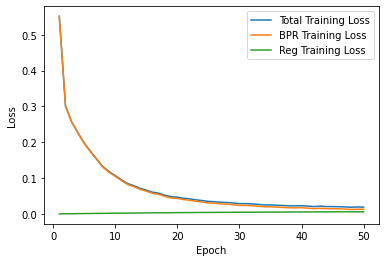

In [ ]:
plt.plot(epoch_list, light_loss, label='Total Training Loss')
plt.plot(epoch_list, light_bpr, label='BPR Training Loss')
plt.plot(epoch_list, light_reg, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

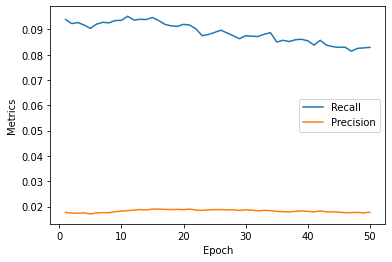

In [ ]:
plt.plot(epoch_list, light_recall, label='Recall')
plt.plot(epoch_list, light_precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

In [ ]:
max(light_precision), max(light_recall)

(0.019, 0.0952)